# 201601990 김충환 중간고사 대체과제


### A) 구현자 정보 : 
알고리즘응용(00반) 201601990 김충환입니다.


### B) 구현하려는 주제, 문제 적용

=> 구현하려는 주제는 Clustering중 DBSCAN입니다. 

=> 문제 적용 : 대전시에서 자영업을 시작하려는 사람들에게 지역을 추천해줄 때, 매출액/부동산 가격을 기준으로 [동]을 선정하고, 그 지역의 상가들을 DBSCAN을 통해 군집화하여 상가가 밀집된 지역을 추천해줄 수 있습니다.


### C) 문제, 데이터
=> 문제 : 대전시에서 소상공인이 자영업을 시작한다고 할 때, 부동산 가격도 괜찮으면서 매출도 좋은 지역을 추천해주고싶습니다.

=> 데이터는 'shoppingmall_02.csv', '상업업무용(매매)_실거래가_20200520.csv', 'card_sales_201901_202003.csv' 를 사용합니다.
   
   각각 상가 정보 데이터, 부동산 가격 데이터, 카드 사용액(매출액)데이터 입니다.

### D) 전체적인 <과정>은 다음과 같습니다. 

    1. 대전시의 매출액 상위 20위 지역 중, 부동산 가격 대비 매출액이 가장 높은 지역을 선정합니다.

    2. 그 지역의 좌표를 사용해 Clustering을 한 후, 상가 밀집도가 높은 지역을 추천해줍니다.

## ■■■■■ 주의 사항 ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

    Colab에서 실행할 경우 shoppingmall_02 데이터가 업로드 되는데에 
    
    ◀매우 오랜 시간(제 컴퓨터 기준 30~40분)▶이 걸립니다.(column 39, row 530,000)

    shoppingmall_02는 전국에 있는 상가 정보를 모아놓은 데이터로, 그 중간 중간에 [대전시]에 대한 데이터가 있습니다.

    따라서 데이터가 모두 업로드되지 않은 상태에서 실행하면 결과가 이상하게 나올 수 있습니다!

    tqdm으로 데이터를 지도에 표시하는 정도를 표시해줬고 신성동에 대한 데이터는 총 1176개 입니다.

    1176개가 나오지 않는다면 아직 shoppingmall_02 데이터가 모두 업로드되지 않은 상태입니다!

    ◀csv파일이 매우 크므로 Jupyter에서 실행하는 것이 훨씬 빠릅니다!▶
    
    ==========================================================================
    
    ★ 중요 : colab에서 실행할 경우 한글 깨짐 방지 코드가 실행되면 그 후 utf-8 인코딩 문제가 뜨면서
    
    실행이 안되는 경우가 간혹 있는데, 이런 경우는 일단 파일이 모두 업로드 될 때까지 기다립니다(30분+a). 
    
    그 후, [런타임 다시시작]을 한 후 처음부터 실행하면 문제없이 잘 실행됩니다.
    
###     << 웬만하면 Jupyter notebook으로 실행하는 것을 권장드립니다!! (데이터가 너무 커서 colab에 업로드하는 데에 

### 많은 시간이 소요되기 때문) >>
## ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

# 0. 필요 라이브러리 import

※ 라이브러리가 없을 경우 주석을 해제하고 설치해주시면 됩니다!

In [1]:
# pip install platform
# pip install numpy
# pip install pandas
# pip install seaborn
# pip install matplotlib
# pip install folium
# pip install tqdm
# pip install sklearn

In [2]:
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium

from matplotlib import font_manager, rc
from tqdm import tqdm
from sklearn.cluster import DBSCAN

# 1. 부동산 대비 매출액을 기준으로 동네 선정

### 0 - 1) 한글 깨짐 방지

그래프를 그릴 때 한글이 깨지는 것을 방지하기 위한 코드입니다.

In [3]:
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

### 0 - 2) 한글 깨짐 방지(★★코랩 사용시에만 주석 제거하고 사용★★)

#### 밑의 코드는 코랩을 사용할 경우에만 주석을 제거하고 사용하시면 됩니다!
#### 주석을 제거한 후 ★★ 꼭 런타임을 다시 시작해야합니다! ★★

#### 따라서 Colab에서 실행할 때는 : [주석 제거 > 런타임 다시 시작 > 파일 업로드 > 실행] 의 순서로 실행합니다.
#### 이 코드를 실행하면 코랩에서 밑의 그래프의 한글이 깨지지 않고 제대로 나옵니다.

In [4]:
# import matplotlib as mpl
# import matplotlib.pyplot as plt
 
# %config InlineBackend.figure_format = 'retina'
 
# !apt -qq -y install fonts-nanum
 
# import matplotlib.font_manager as fm
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font = fm.FontProperties(fname=fontpath, size=9)
# plt.rc('font', family='NanumBarunGothic') 
# mpl.font_manager._rebuild()

### 1) 매출액

'data/card_sales_201901_202003.csv' 데이터를 활용하여 각 행정동 별 매출액을 구합니다.

In [5]:
card_sales = pd.read_csv('data/card_sales_201901_202003.csv', encoding='euc-kr')

card_sales = card_sales[['행정동', '매출액']]
card_sales['행정동'] =card_sales['행정동'].str.replace('\d+', '')

data1 = card_sales.groupby(['행정동'])['매출액'].sum().reset_index()
data1 = data1.sort_values(["매출액"], ascending=[False])

### 2) 부동산 가격

'data/상업업무용(매매)_실거래가_20200520.csv'데이터를 활용하여 각 행정동별 면적당 부동산 거래가를 구합니다.

In [6]:
price= pd.read_csv('data/상업업무용(매매)_실거래가_20200520.csv')

data2 = {
    "행정동": price['시군구'].str.split(' ').str[2],
    "면적당거래가": price['거래금액(만원)'].div(price['전용/연면적(㎡)'].astype(int))
}

df = pd.DataFrame(data2)

data2 = pd.DataFrame(df.groupby(['행정동'])['면적당거래가'].sum().reset_index())
data2 = data2.sort_values(["면적당거래가"], ascending=[False])

### 3) 부동산 가격대비 매출액 + 시각화

위에서 추출한 data를 병합하고, 매출액 기준으로 정렬합니다.

매출액 기준 상위 20곳은 부동산 거래액까지 고려해서

매출액/부동산 거래액을 기준으로 상위 10곳을 선정하여 그래프를 그립니다.

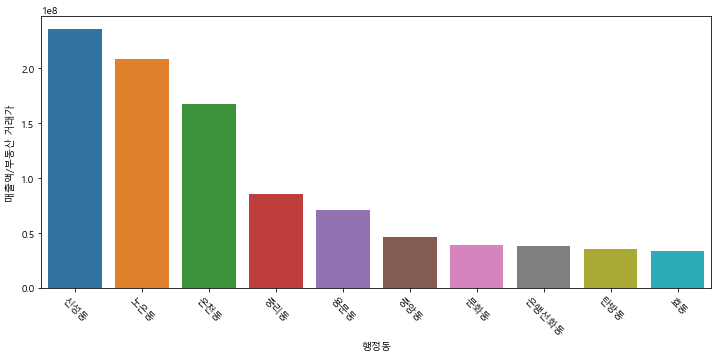

In [7]:
total = pd.merge(data1, data2, on='행정동', how='outer')

total['매출액'] = total['매출액'].fillna(total['매출액'].mean())
total['면적당거래가'] = total['면적당거래가'].fillna(total['면적당거래가'].mean())

total = {
    "행정동": total['행정동'],
    "total": total['매출액'].div(total['면적당거래가']),
    "매출액": total['매출액']
}

total = pd.DataFrame(total)

total = total.sort_values(["매출액"], ascending=[False])
total = total[:20].sort_values(["total"], ascending=[False])
total = total[:10]


plt.figure(figsize=(12,5))
ax = sns.barplot(x=total['행정동'], y=total['total'])
ax.set(xlabel='행정동', ylabel='매출액/부동산 거래가')
plt.xticks(rotation = - 45 )
plt.show()

# 2. 선정한 동네의 좌표를 DBSCAN을 통해 Clustering

### 1) 필요 함수 정의

##### => read_data(path) :
'data/shoppingmall_02.csv' 데이터를 받아

[신성동]의 (위도, 경도), 위도, 경도를 리턴해주는 함수입니다.

###### => make-marker(map_osm, x, y, labels):

map과, x, y좌표, labels을 받아 지도에 표시해주는 함수 입니다.

In [8]:
def read_data(path):

    location = pd.read_csv(path, sep='|')
    location = location[['위도', '경도', '행정동명']]
    location = location.drop(location[location['행정동명'] != '신성동'].index)

    x = np.array(location['위도'])
    y = np.array(location['경도'])

    return location[['위도','경도']], x, y



def make_marker(map_osm, x, y, labels):


    for i in tqdm(range(len(x))):
        if labels[i] == -1:
            color = 'black'
        elif labels[i] == 0:
            color = 'red'
        elif labels[i] == 1:
            color = 'blue'
        else:
            color = 'yellow'

        folium.CircleMarker([x[i], y[i]], radius=2, color= color, fill_color = 'blue').add_to(map_osm)

### 2) DBSCAN한 결과를 지도에 표시

신성동의 좌표를 통해 DBSCAN을 하고 그 결과를 지도에 표시해줍니다.

In [9]:
path = 'data/shoppingmall_02.csv'

data, x, y = read_data(path)

data = np.array(data, dtype=float)

clustering = DBSCAN(eps=0.001, min_samples=50).fit(data)
center = [36.3901125667739, 127.35945143459531]
map_osm = folium.Map(location=center)
make_marker(map_osm, x, y, clustering.labels_)

map_osm    

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3248: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
100%|███████████████████████████████████████████████████████████████████████████| 1176/1176 [00:00<00:00, 17563.57it/s]


## <결과>

#### 대전시 매출액 상위 20곳 중, 부동산 가격 대비 매출액이 가장 높은 곳은 "신성동"입니다.
#### 신성동의 상가 좌표를 DBSCAN을 통해 Clustering하였고, noise는 검정색으로 표시하였습니다.
#### 위 지도에서 알 수 있듯이 [빨간색] 부분과 [파란색] 부분이 상가 밀집도가 높으므로 
### 자영업을 시작하려는 소상공인들에게 위 지역을 추천해줄 수 있습니다.